# STARGAN

## Introduction

The task of image-to-image translation is to change a given aspect of a given image to another,i.e, changing the facial expression of a person from neutral to happy. 
![alt text](https://drive.google.com/uc?export=view&id=1KlhqDgBpDjzZ9_9zTbpNIxbUfXDhDdqf)

Recent works have achieved significant results in this area. However, existing approaches have limited scalability and robustness in handling more than two domains. As we have studied CycleGAN create a different network for each pair of image domain. If we suppose we need to translate images to 7 domains, in this case, we would need 7 different generators and discriminators.

For instance, StarGAN is a type of Generative Adversarial Network (GAN) that solves the problem of a multi-domain image to image translation. The basic idea is to train a single generator G that learns mappings among multiple domains and this is why it is called `Star`. 

![alt text](https://drive.google.com/uc?export=view&id=1GZ-Gt11xre3KF_8O3xfVvPCw7af8CXjq)

To reach this, we need to train G to translate an input image x to an output image y conditioned on the target domain label c, G(x, c) → y. We randomly generate the target domain label c. An auxiliary classifier was introduced that allows a single discriminator to control multiple domains.

## Learning Objectives

* Understand Data preprocessing
* To be able to explain Network architecture and loss functions
* Training StarGAN

## Steps to run this notebook from Colaboratory

This colab will run much faster on GPU. To use a Google Cloud
GPU:

1. Go to `Runtime > Change runtime type`.
1. Click `Hardware accelerator`.
1. Select `GPU` and click `Save`.
1. Click `Connect` in the upper right corner and select `Connect to hosted runtime`.

### Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Upload Data from kaggle
1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

3. Go to your Google Colab project file and run the following commands:

```
! pip install -q kaggle
``` 
```
from google.colab import files
files.upload() #Choose the kaggle.json file that you downloaded
```
```
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/ #Make directory named kaggle and copy kaggle.json file there.
! chmod 600 ~/.kaggle/kaggle.json # Change the permissions of the file.
```

5) That's all ! You can check if everything's okay by running this command.
```
! kaggle datasets list
```

### Download Data
```
! kaggle datasets download -d jessicali9530/celeba-dataset
```

Use unzip command to unzip the data:

```
! mkdir train #Create a directory named train
! unzip train.zip -d train #unzip train data there
```

## Imports (RUN ME!)
Make sure to run the imports cell above, otherwise the rest of the cells will fail when you try to run them. (To run a cell press `shift` + `enter` with your mouse cursor in the cell or press the play button in the top right of the cell.)

In [2]:
%load_ext tensorboard

import csv
import os
import glob
import time
import random

import functools
import numpy as np
import tqdm

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as keras
import tensorflow_addons as tfa
%matplotlib inline

## Configs

In [3]:
# Experiment paths
EXPERIMENT_ID = "train"
MODEL_SAVE_PATH = os.path.join("/content/drive/My Drive/lecture hands on lab/StarGAN", EXPERIMENT_ID)
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)
CHECKPOINT_NAME = "checkpoint"
CHECKPOINT_PATH = os.path.join(MODEL_SAVE_PATH, CHECKPOINT_NAME)


# Data
DATA_PATH = '/content/drive/My Drive/lecture hands on lab/StarGAN/data/celeba-dataset/img_align_celeba/img_align_celeba/*'
ATTRIBUTE_PATH = '/content/drive/My Drive/lecture hands on lab/StarGAN/list_attr_celeba.csv'
ATTRIBUTES = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Mustache', 'Young']


# Model parameters
EPOCHS = 100
N_CRITIC = 5
BATCH_SIZE = 64 
IMG_SHAPE = (128, 128, 3)
NUM_CLASS = 5
AUTOTUNE = tf.data.experimental.AUTOTUNE
LR = 0.0001 
BETA = 0.5

# A fixed random seed is a common "trick" used in ML that allows us to recreate
# the same data when there is a random element involved.
seed = random.seed(30)

## Data understanding and exploration

We will be using Images from (CelebA) Dataset from [Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset).
Images cover large pose variations, background clutter, diverse people, supported by a large quantity of images. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong. It contains 202,599 number of face images of various celebrities.

This dataset consists of two type of data images and csv file entitled `list_attr_celeba.csv` with attributes values. Each correspond for each image as "black/ blond/ brown" for hair color or "male/ female" for gender.

### **Let's discover the images**!

In [ ]:
def get_images_paths(path):
    img_paths = []
    for filename in glob.glob(path):
        img_paths.append(filename)
    return list(img_paths)

In [ ]:
img_paths = get_images_paths(DATA_PATH)
for image_path in img_paths[:2]:
    image = mpimg.imread(str(image_path))
    plt.figure()
    plt.axis('off')
    plt.imshow(image)

In [ ]:
image_size = []
for filename in img_paths:
    im=Image.open(filename)
    im =im.size
    image_size.append(im)
print(max(image_size))
print(min(image_size))

(178, 218)
(178, 218)


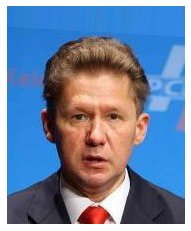

In [ ]:
# Read in the image
image = mpimg.imread(img_paths[30])

plt.axis("off")
plt.imshow(image)

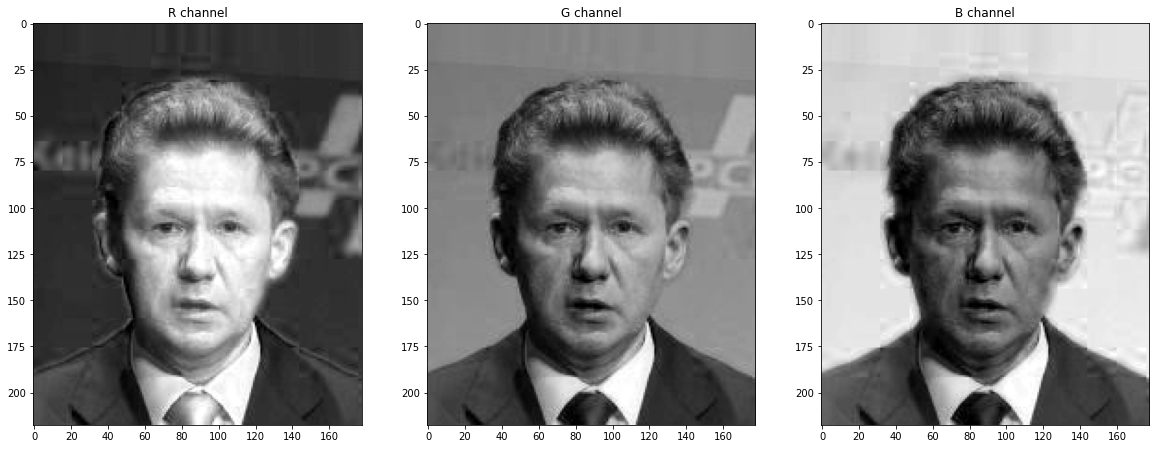

In [ ]:
# Isolate RGB channels
r = image[:,:,0]
g = image[:,:,1]
b = image[:,:,2]

# Visualize the individual color channels
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('R channel')
ax1.imshow(r, cmap='gray')
ax2.set_title('G channel')
ax2.imshow(g, cmap='gray')
ax3.set_title('B channel')
ax3.imshow(b, cmap='gray')

### Attributes time !

In [9]:
attribute_file = open(ATTRIBUTE_PATH, "r")
for x in attribute_file:
    print(x)

Streaming output truncated to the last 5000 lines.

021201.jpg,-1,1,1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,1,-1,1,-1,1,-1,1,1,-1,-1,-1,1,1,-1,1

021202.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,1

021203.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,1

021204.jpg,-1,1,1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,1,1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,1

021205.jpg,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1

021206.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1

021207.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,1

021208.jpg,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.

062808.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,1,-1,-1,1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1

062809.jpg,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,-1,1,-1,-1,1,-1,1,1,-1,1,-1,-1,1

062810.jpg,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1

062811.jpg,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1

062812.jpg,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1

062813.jpg,-1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1

062814.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1

062815.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.

106126.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1

106127.jpg,-1,-1,-1,1,-1,1,-1,1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1

106128.jpg,-1,-1,1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1

106129.jpg,-1,-1,1,1,-1,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,1,-1,1

106130.jpg,-1,1,1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1

106131.jpg,-1,1,1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,1,-1,1

106132.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1

106133.jpg,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.

150116.jpg,-1,-1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1

150117.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1

150118.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,1,-1,-1,1

150119.jpg,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,1

150120.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,1

150121.jpg,-1,-1,-1,1,-1,1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1

150122.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,1,1,-1,-1,-1,-1,-1

150123.jpg,1,-1,1,1,-1,1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.

196615.jpg,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1

196616.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1

196617.jpg,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1

196618.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,1,1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,1

196619.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,1

196620.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,1,-1,-1,-1,1,-1,1,-1,1,1,-1,1,-1,-1,1

196621.jpg,-1,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1

196622.jpg,-1,1,1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



These attributes files contain 202599 rows. Each row represents one image by its file name. For each row, we have 40 attributes. Each image will be annotated by all the attributes:
* The attribute value is `1` if the quality exists in the image 
* The attribute value is `-1` if the quality doesn't exist in the image

**After checking data quality:**
* **202,599 Diverse images**
* **All images have the same size (178, 218)**
* **The images are RGB**
* **All images are annotated**

## Data Pipeline

We start by preparing the labels. We will use a label binary vector to represent domain information.
![alt text](https://drive.google.com/uc?export=view&id=1iE7yFeJY5dr0VuzNlivrYYx6cDPkUXei)


We will focus on 5 domain ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Mustache', 'Young']
The steps that will be done to encode the attributes:
* Find for the attributes that we have chosen their column index
* Create empty lists with the length of attributes vectors 
* Looping through each row and find if the chosen attributes is equal to one or no

In [14]:
attr_info_array = []

In [15]:
with open(ATTRIBUTE_PATH, 'r') as f:
    reader = csv.reader(f)
    for row in reader: # each row is a list
        attr_info_array.append(row)
attr2idx = {}
idx2attr = {}
for i, attr in enumerate(attr_info_array[0]):
    if attr in ATTRIBUTES:
        attr2idx[attr] = i
        idx2attr[i] = attr

In [16]:
attr2idx

{'Black_Hair': 9,
 'Blond_Hair': 10,
 'Brown_Hair': 12,
 'Mustache': 23,
 'Young': 40}

In [17]:
image_label = [[0. for _ in range(len(ATTRIBUTES))] for _ in range(len(attr_info_array[1:]))] # Initialize vectors by zero
for i, attr in enumerate(attr_info_array[1:]):
    cols = attr[:]
    for j, attr in enumerate(ATTRIBUTES):
        if cols[attr2idx[attr]] == '1':
            image_label[i][j] = 1.

### Preparing DataLoader

![alt text](https://drive.google.com/uc?export=view&id=1xe7O6sTg1HxbM_Fc8p57gGXB9keeaDjC)

We will be using Data API provide it by TensorFlow. What we have to do is create a dataset object, tell it where to get the data, then transform it in any way we want, and TensorFlow takes care of all the implementation details, such as multithreading, queuing, batching, prefetching, and so on.\
(1) Create dataset entirely in RAM using tf.data.Dataset.from_tensor_slices() \
(2) Call shuffle to ensure that the training set are independent and identically distributed. \
NB:  the buffer size must be specified, and it is important to make it large enough or else shuffling will not be very efficient.\
(3) Do the necessary transformation by calling the map() method. \
(4) Call the batch() method. It will group the items of the previous dataset in batches of n items. \
(5) Using prefetch will let the dataset work on parallel with training algorithm to get the next batch ready.

Images will be scaled from range [0,255] to [-1,1].

During training, we randomly generate a target domain label and train the model to flexibly translate an input image into the target domain. By doing so, we can control the domain label and translate the image into any desired domain at testing phase.

In [ ]:
@tf.function
def preprocessing_data(path, image_label, target_label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128,128])
    image = tf.cast(image, dtype=tf.float32)
    image = (image / 127.5) - 1
    return image, image_label, target_label

In [ ]:
def dataloader():
    images = tf.data.Dataset.from_tensor_slices(img_paths)
    ori_label_ds = tf.data.Dataset.from_tensor_slices(image_label)
    tar_label_ds = tf.data.Dataset.from_tensor_slices(image_label).shuffle(10*BATCH_SIZE)
    dataset = tf.data.Dataset.zip((images, ori_label_ds, tar_label_ds))
    dataset = dataset.map(lambda x, y, z: preprocessing_data(x, y, z), num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [ ]:
train_dataset = dataloader()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


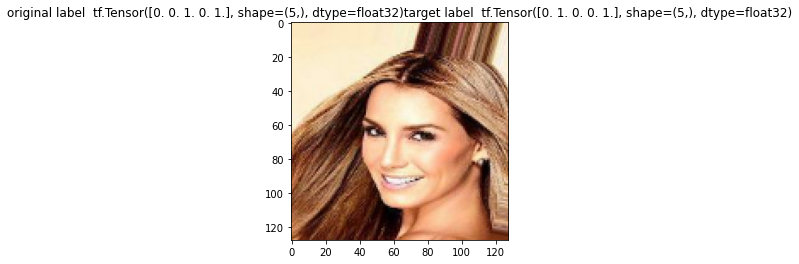

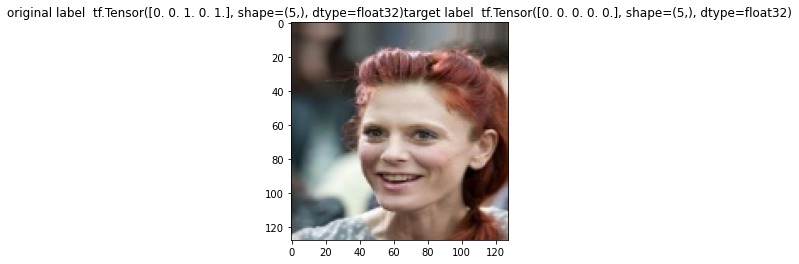

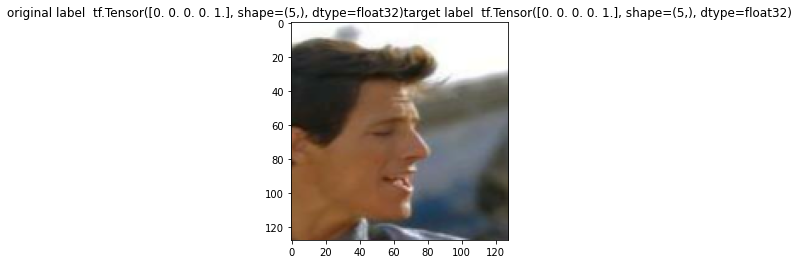

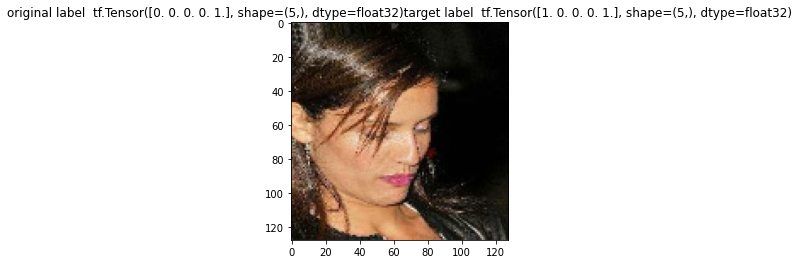

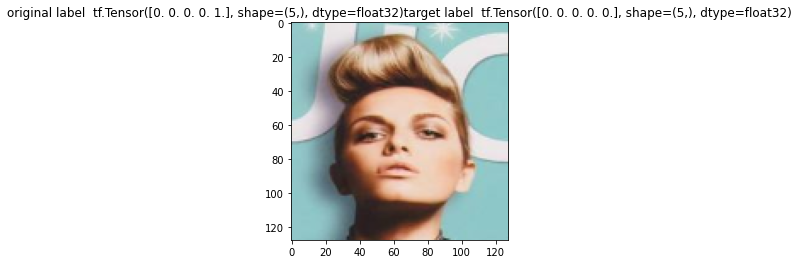

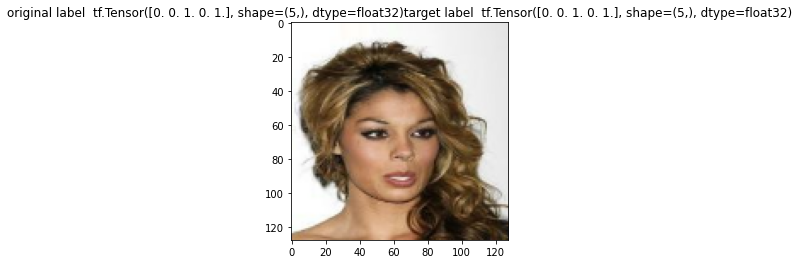

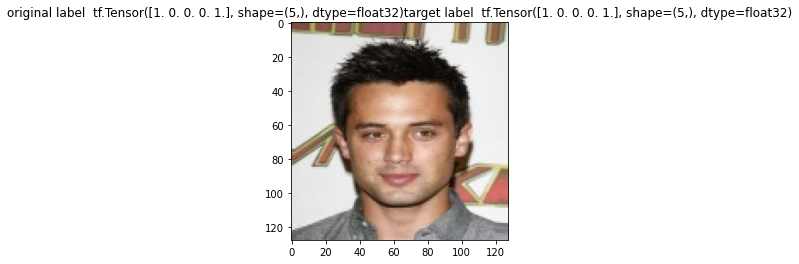

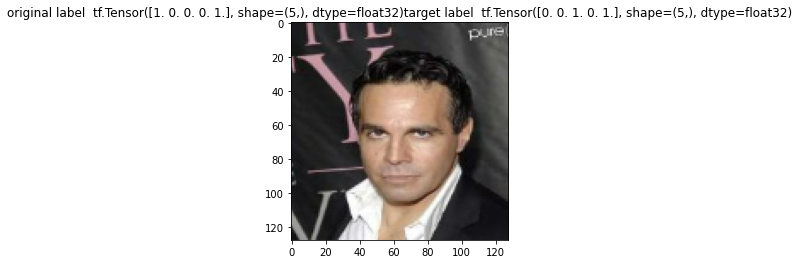

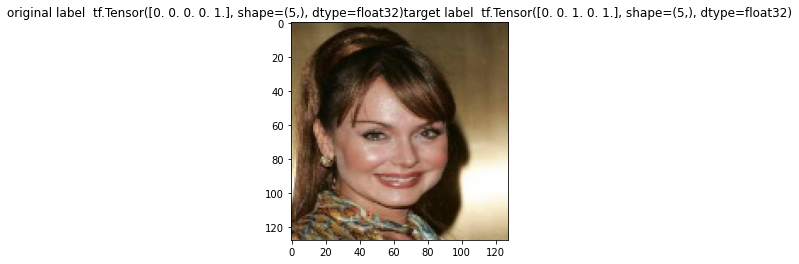

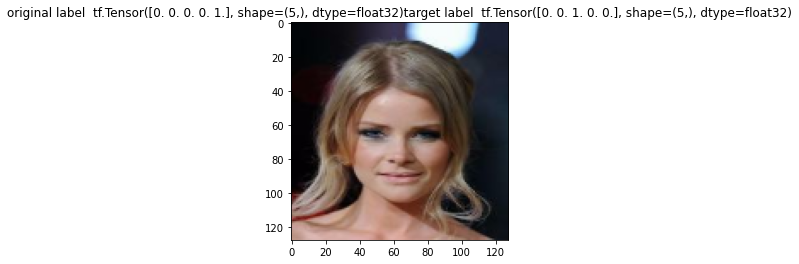

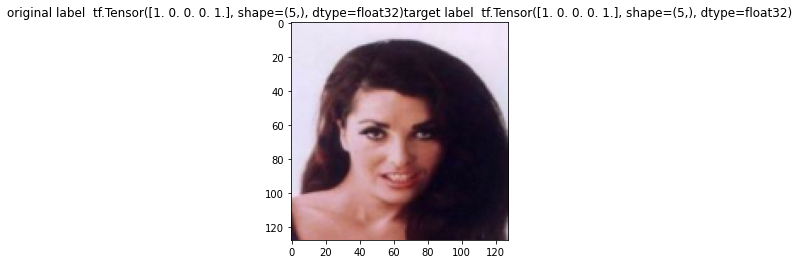

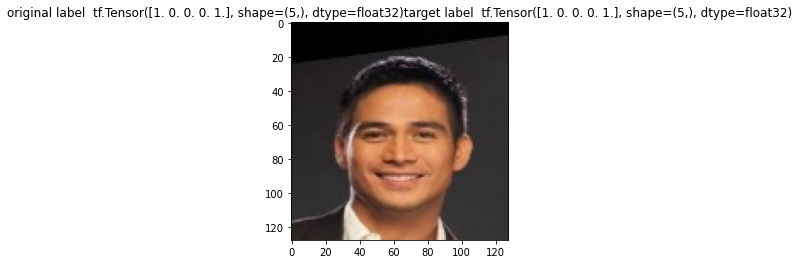

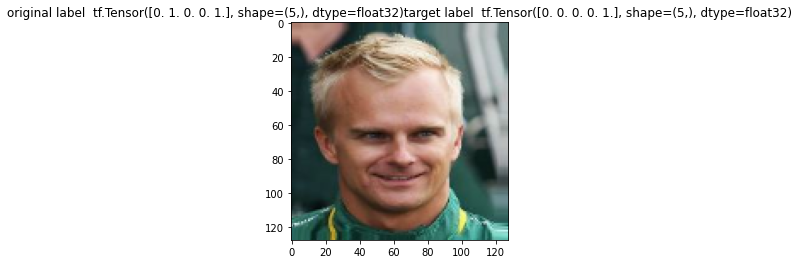

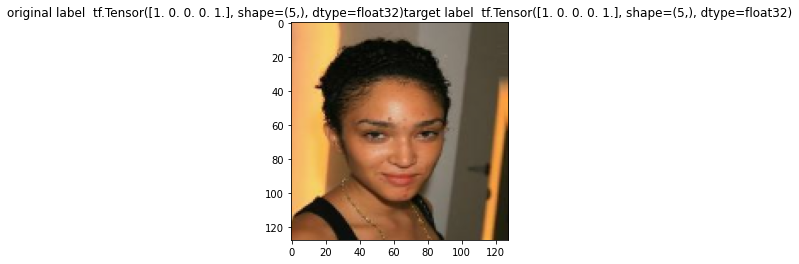

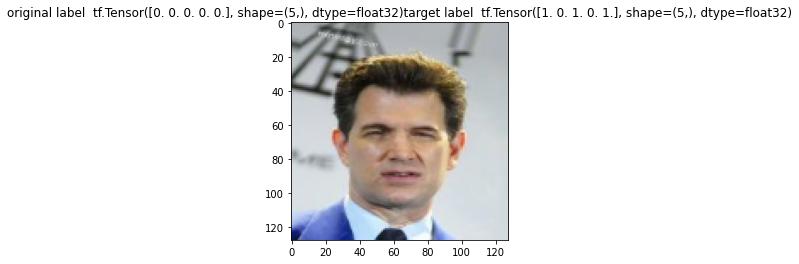

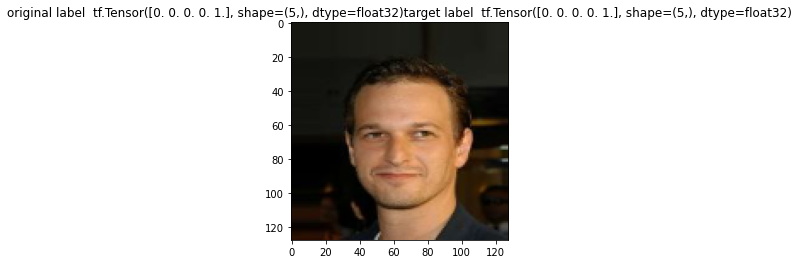

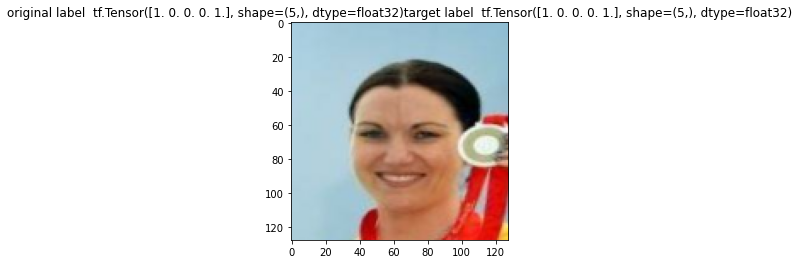

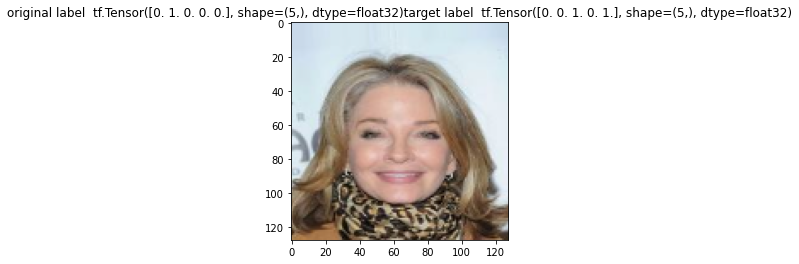

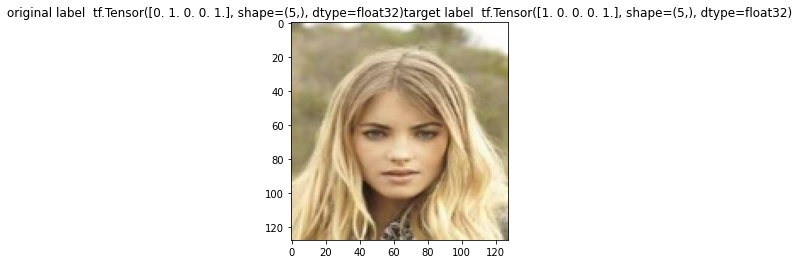

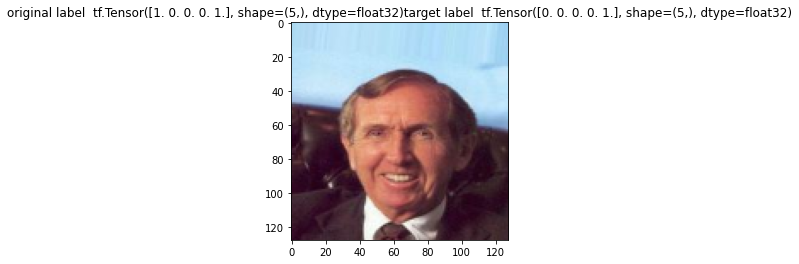

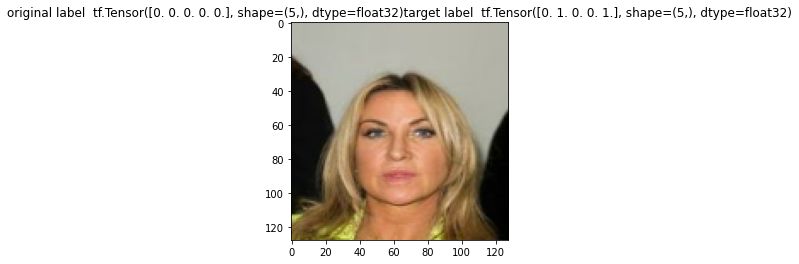

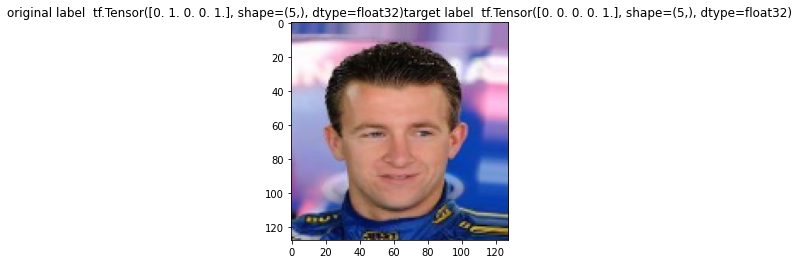

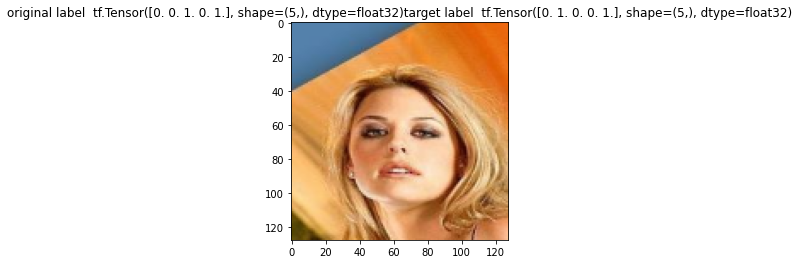

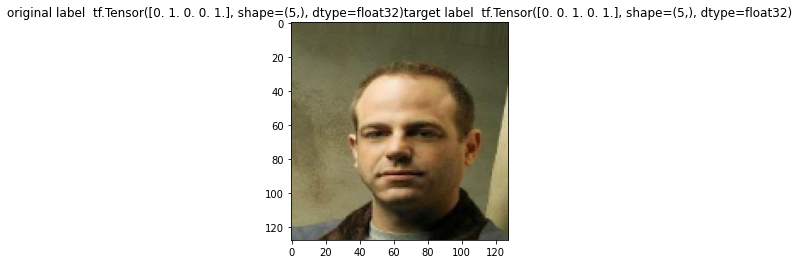

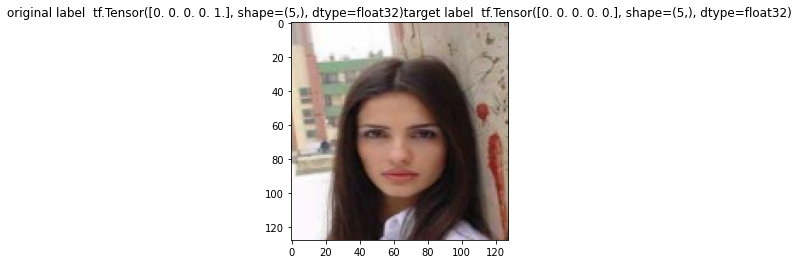

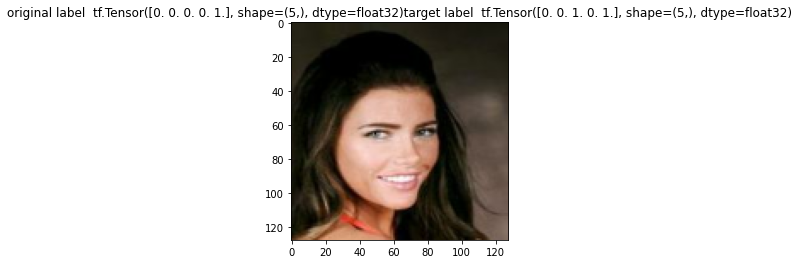

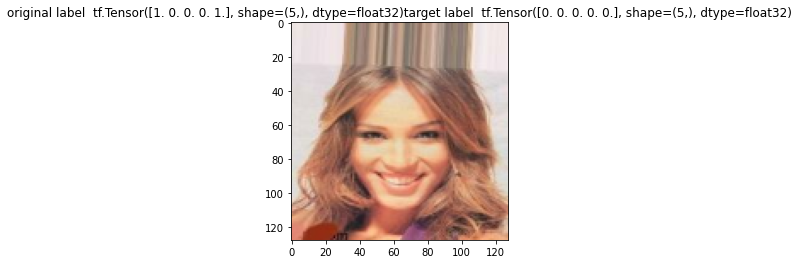

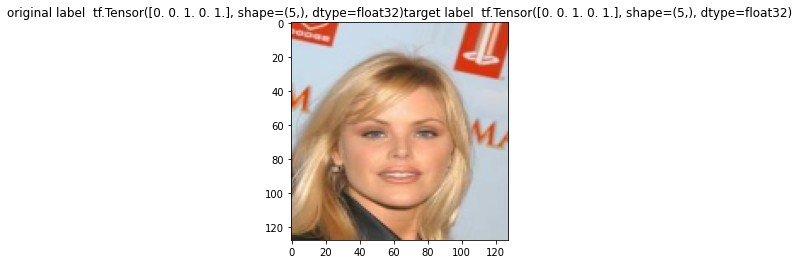

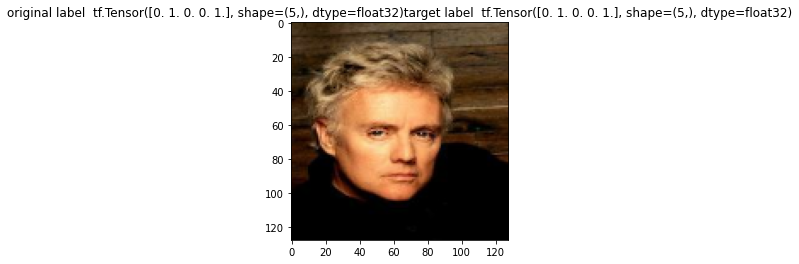

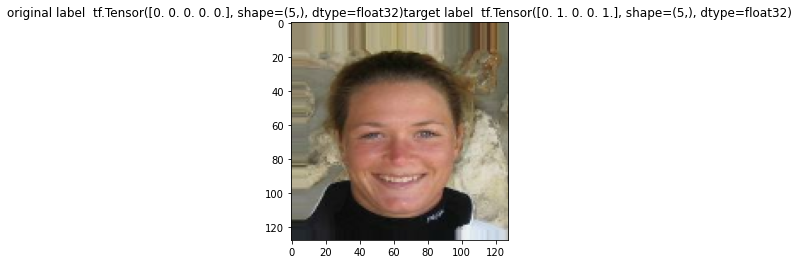

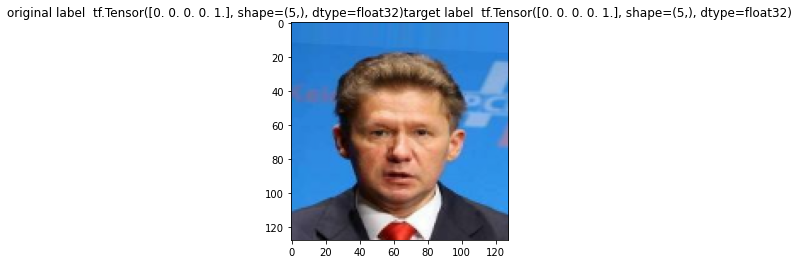

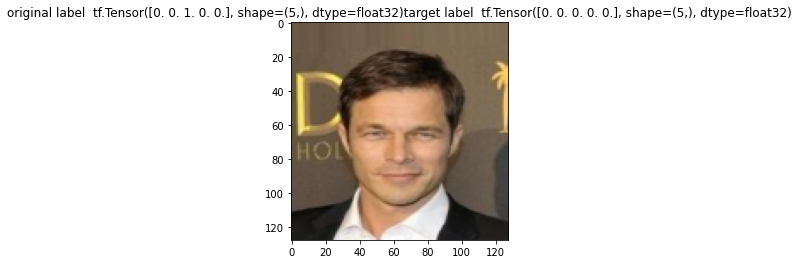

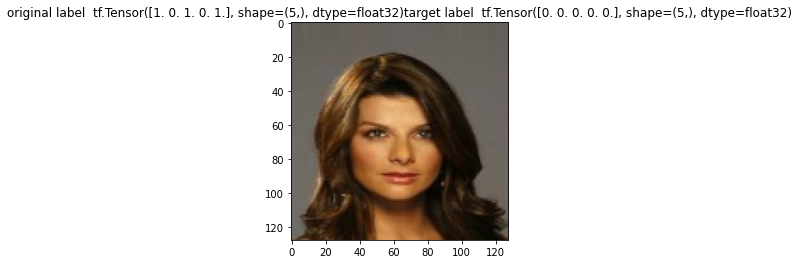

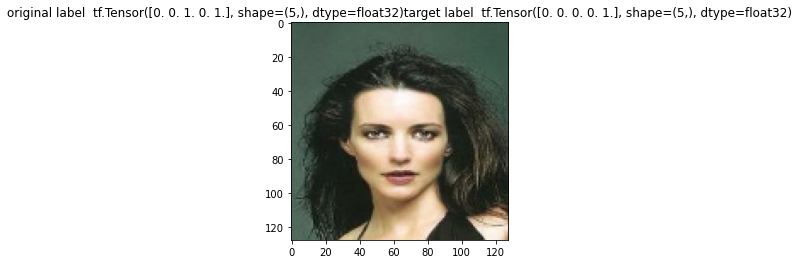

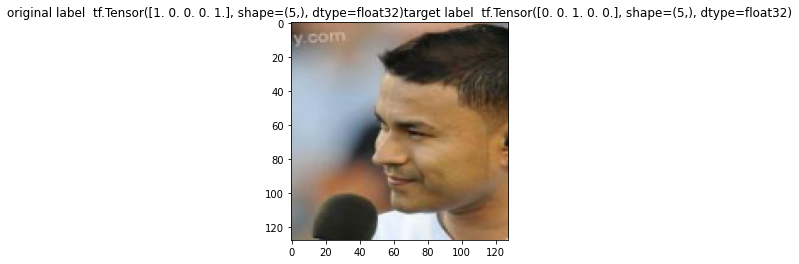

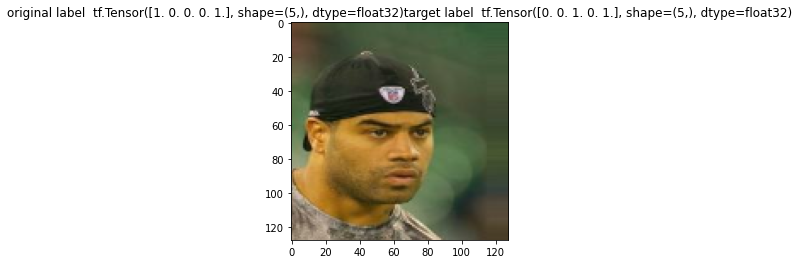

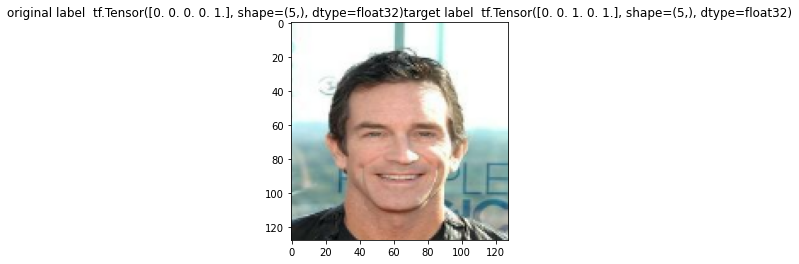

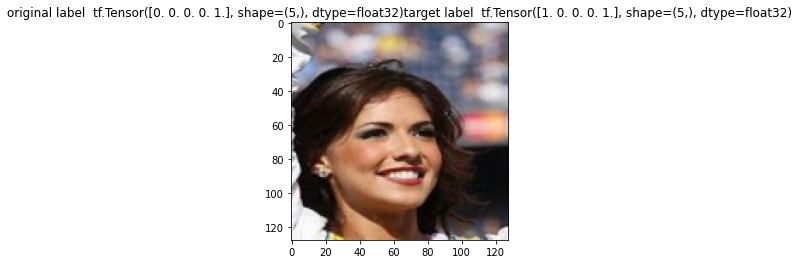

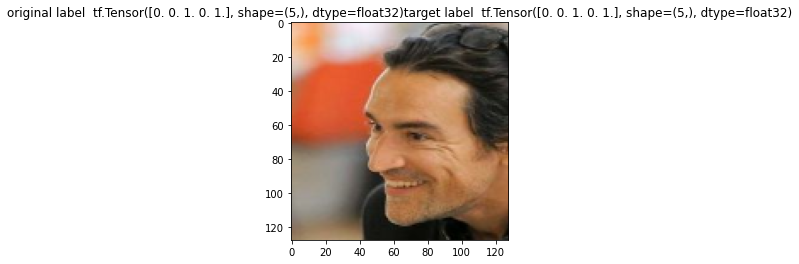

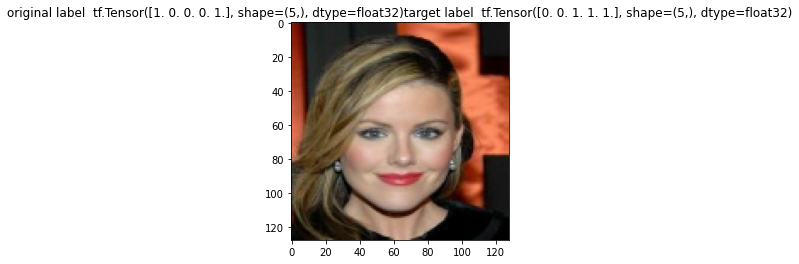

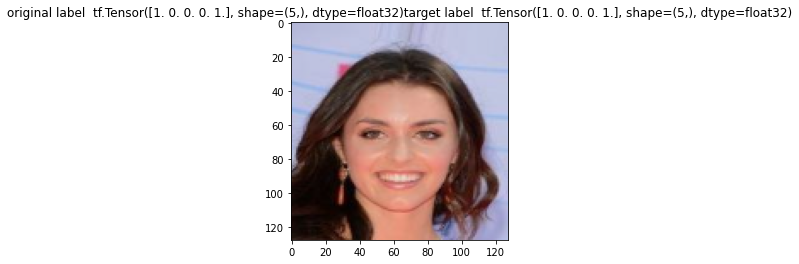

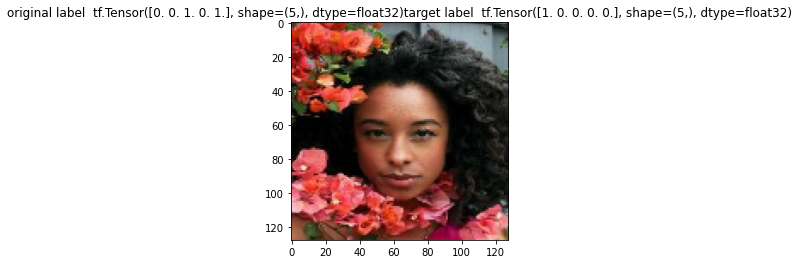

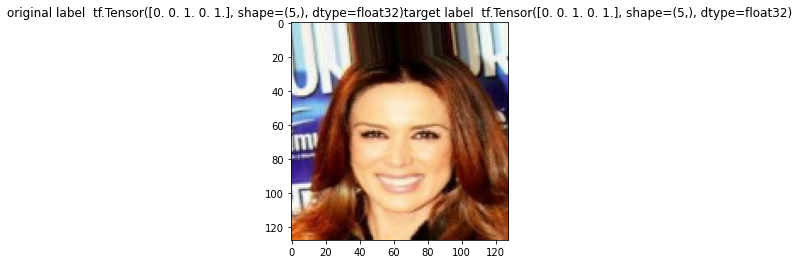

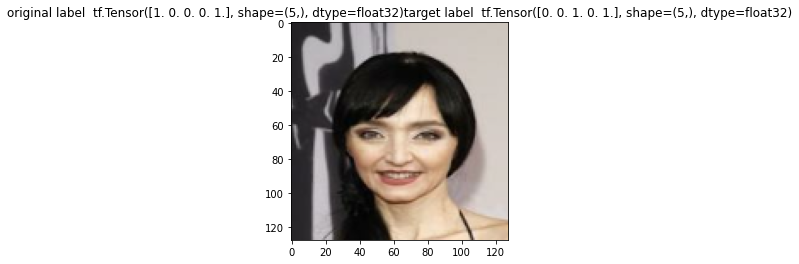

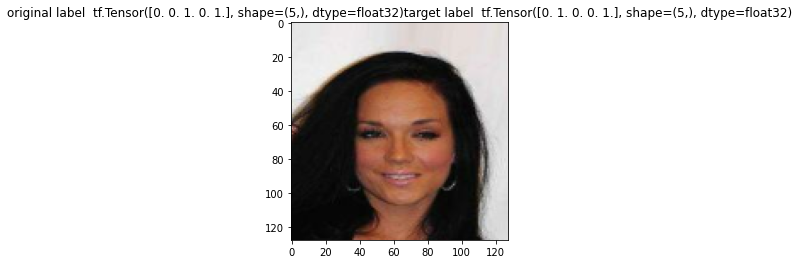

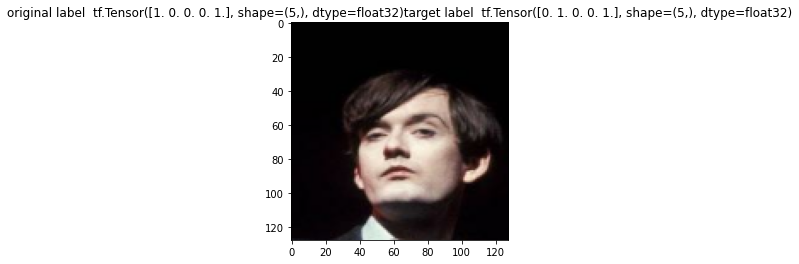

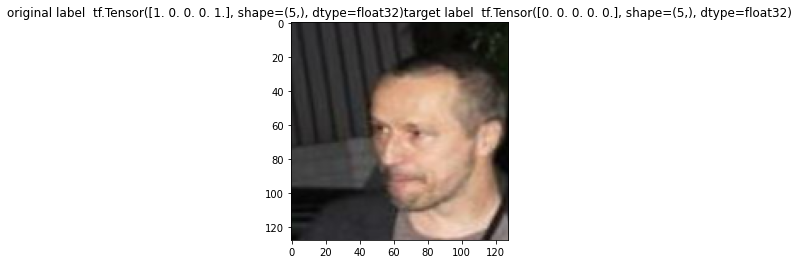

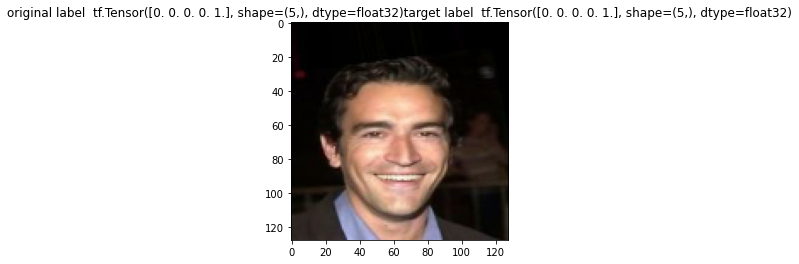

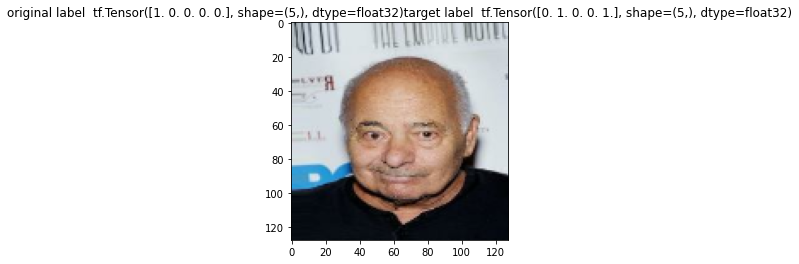

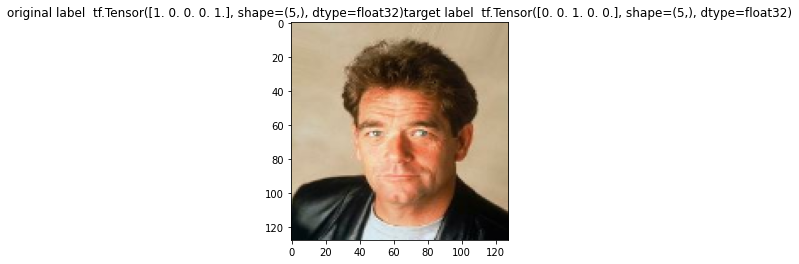

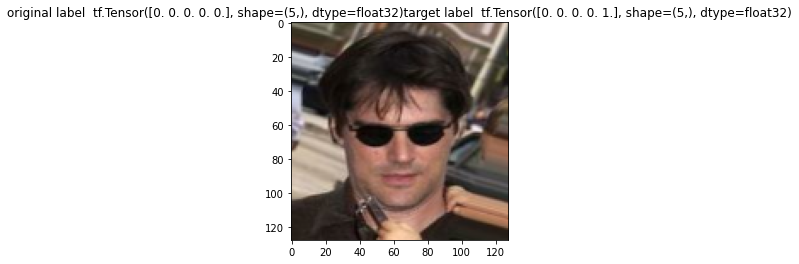

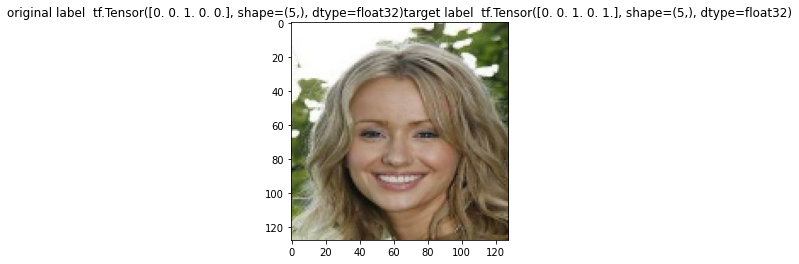

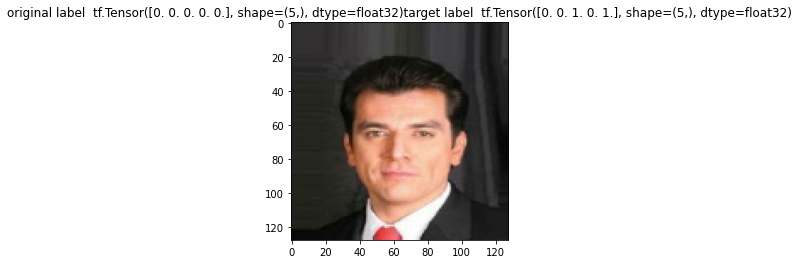

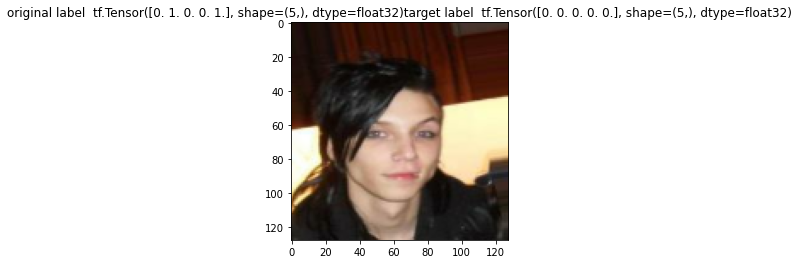

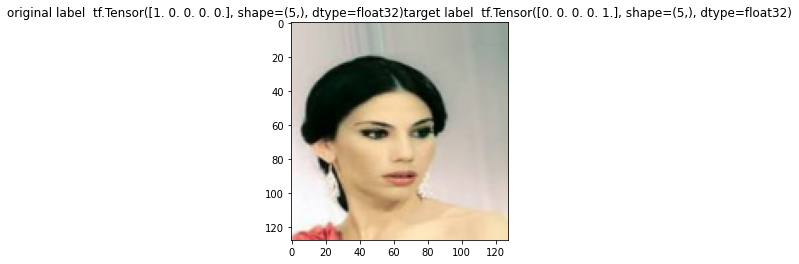

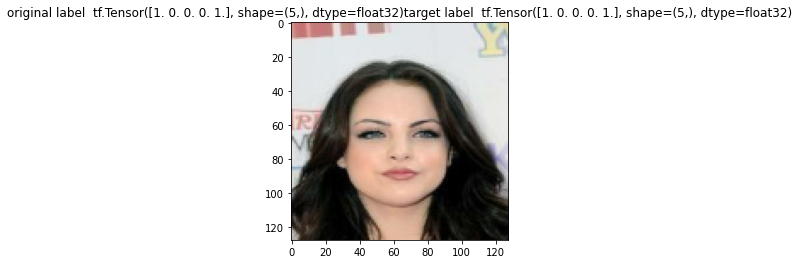

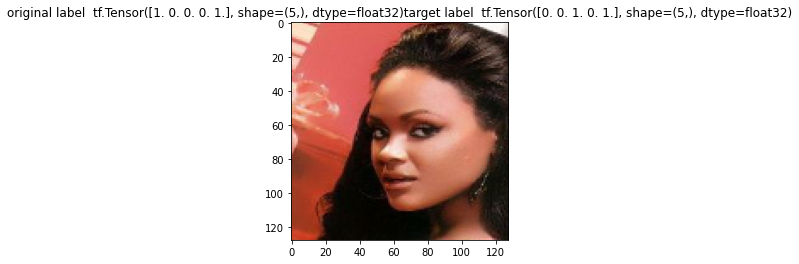

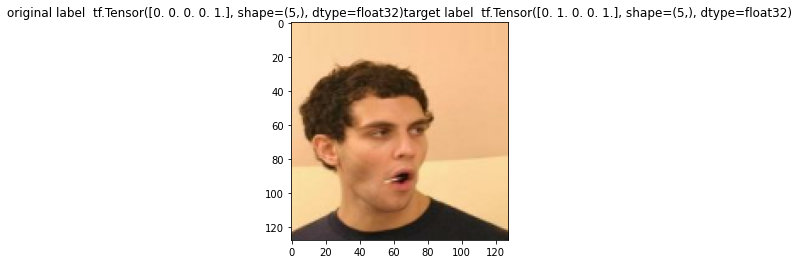

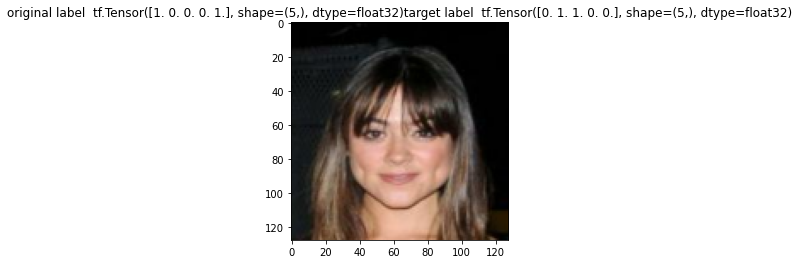

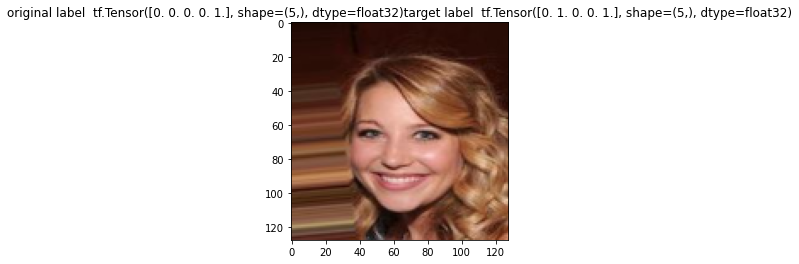

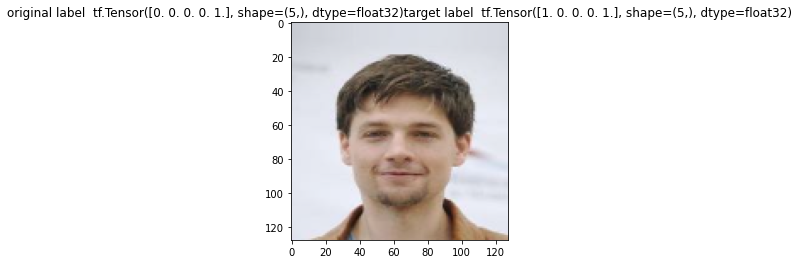

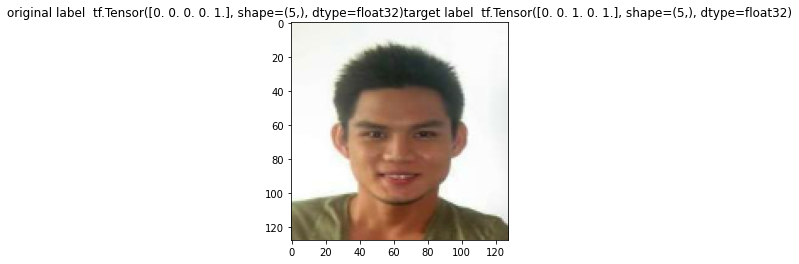

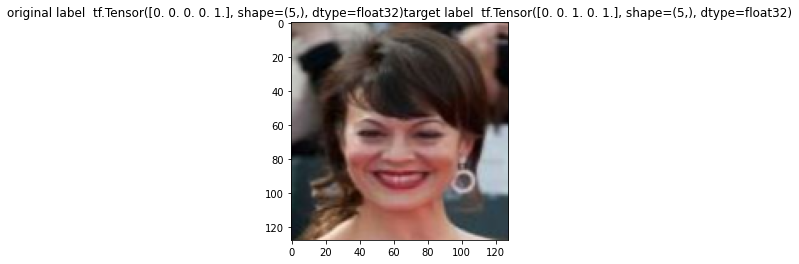

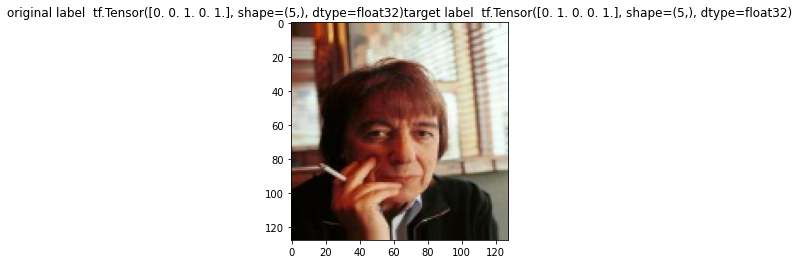

In [ ]:
for images, ori_labels, tar_labels in train_dataset.take(1):
    for img, o_label, t_label in zip(images, ori_labels, tar_labels):
        img_np = img.numpy()
        plt.figure()
        plt.title("original label  " + str(o_label)+ "target label  " +str(t_label))
        plt.imshow((img_np-img_np.min())/(img_np.max()-img_np.min()))
 #       ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Mustache', 'Young']

## Model Setup

StarGAN consist of two modules, a discriminator D and a generator G.


![alt text](https://drive.google.com/uc?export=view&id=1XIqPMI5ykIcsJL7HD_Ob66oKhZ_0ZlXO)


(a) D learns to distinguish between real and fake images and classify the real images to its corresponding domain.

(b) G takes in as input both the image and target domain label and generates an fake image. The target domain label is spatially replicated and concatenated with the input image.

(c) G tries to reconstruct the original image from the fake image given the original domain label.

(d) G tries to generate images indistinguishable from real images and classifiable as target domain by D.

### Generator


In [ ]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, dim, norm_layer, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, norm_layer, use_bias)

    def build_conv_block(self, dim, norm_layer, use_bias):
        conv_block = []
        p = 'same'

        conv_block += [tf.keras.layers.Conv2D(dim, (3, 3), padding=p, use_bias=use_bias), 
                       norm_layer(), 
                       tf.keras.layers.Activation('relu')]

        conv_block += [tf.keras.layers.Conv2D(dim, (3, 3), padding=p, use_bias=use_bias), 
                       norm_layer()]

        return tf.keras.Sequential(conv_block)

    def call(self, x, training=True):
        out = x + self.conv_block(x, training=training)
        return out

In [ ]:
class Generator(tf.keras.layers.Layer):
    def __init__(self, 
                 channels=3,
                 ngf=64,
                 norm_layer=tfa.layers.normalizations.InstanceNormalization,
                 use_bias=False,
                 n_blocks=6):

        super(Generator, self).__init__()
        
        self.concat = tf.keras.layers.Concatenate()

        assert(n_blocks >= 0)
        # Encoder
        model = [tf.keras.layers.Conv2D(ngf, (7, 7), padding='same', use_bias=use_bias),
                 norm_layer(),
                 tf.keras.layers.Activation('relu')]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [tf.keras.layers.Conv2D(ngf * mult * 2, (3, 3), strides=(2, 2), padding='same'),
                      norm_layer(),
                      tf.keras.layers.Activation('relu')]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, norm_layer=norm_layer)]

        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [tf.keras.layers.Conv2DTranspose(int(ngf * mult / 2),
                                                      (3, 3), strides=(2, 2),
                                                      padding='same'),
                      norm_layer(),
                      tf.keras.layers.Activation('relu')]

        model += [tf.keras.layers.Conv2D(channels, (7, 7), padding='same'),
                  tf.keras.layers.Activation('tanh')]

        self.model = tf.keras.Sequential(model)

    def call(self, inputs, domains, training=True):
        domains = tf.reshape(domains, (-1, 1, 1, domains.shape[1]))
        domains = tf.tile(domains, tf.constant([1, inputs.shape[1], inputs.shape[2], 1]))
        x = self.concat([inputs, domains])
        return self.model(x, training=training)

### Discriminator

The discriminator as we said later For Auxiliary classifier GAN [(ACGAN)](https://arxiv.org/abs/1610.09585), the input to the discriminator is an image, whilst the output is the probability that the image is real and its class label.
![alt text](https://drive.google.com/uc?export=view&id=1dwtqidlDVuQnlHhb-a9uJXvi9CbQgcQL)

In [ ]:
class Discriminator(tf.keras.layers.Layer):

    def __init__(self, img_shape, nd, ndf=64, n_layers=5, use_bias=False):
        super(Discriminator, self).__init__()

        h, w = img_shape[0:2]

        kw = 4
        model = [tf.keras.layers.Conv2D(ndf, (kw, kw), strides=(2, 2), padding='same'),
                 tf.keras.layers.LeakyReLU(0.01)]

        nf_mult = 1
        for n in range(1, n_layers + 1):
            nf_mult = 2 ** n
            model += [
                tf.keras.layers.Conv2D(ndf * nf_mult, (kw, kw), strides=(2, 2), padding='same'),
                tf.keras.layers.LeakyReLU(0.01)
            ]

        self.model = tf.keras.Sequential(model)

        self.src = tf.keras.layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', use_bias=use_bias)
        
        self.cls = tf.keras.layers.Conv2D(nd, (h // 64, w // 64), strides=(1, 1), padding='valid', use_bias=use_bias)

    def call(self, inputs, training=True):
        x = self.model(inputs, training=training)
        return self.src(x), tf.squeeze(self.cls(x))

In [ ]:
generator = Generator()

In [ ]:
discriminator = Discriminator(IMG_SHAPE, NUM_CLASS)

### Training process

In [ ]:
gen_optimizer = tf.keras.optimizers.Adam(LR, BETA)
disc_optimizer = tf.keras.optimizers.Adam(LR, BETA)

# loss
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
l1 = tf.keras.losses.MeanAbsoluteError()

In [ ]:
def gradient_penalty_loss(averaged_output, x_hat):
    gradients = tf.gradients(averaged_output, x_hat)[0]
    gradients_sqr = tf.square(gradients)
    gradients_sqr_sum = tf.reduce_sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    gradients_l2_norm = tf.sqrt(gradients_sqr_sum)

    gradient_penalty = tf.square(gradients_l2_norm - 1)

    return tf.reduce_mean(gradient_penalty)

def random_weighted_average(inputs):
    alpha = tf.random.uniform((inputs[0].shape[0], 1, 1, 1))
    return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

def discriminator_loss(real_output, fake_output, averaged_output, interpolated_img, lamb_gp=10):
    real_loss = -tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    gp_loss = gradient_penalty_loss(averaged_output, interpolated_img)
    total_loss = real_loss + fake_loss + gp_loss* lamb_gp
    return total_loss

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

def reconstrution_loss(loss_object, real_image, recon_image, lamb_rec=10):
    return loss_object(real_image, recon_image) * lamb_rec 

def domain_classification_loss(loss_object, category, output, lamb_cls=1):
    return loss_object(category, output) * lamb_cls

In [ ]:
@tf.function
def train_generator(images, ori_labels, tar_labels):
    with tf.GradientTape(persistent=True) as tape:
        fake_images = generator(images, tar_labels)
        recon_images = generator(fake_images, ori_labels)

        fake_output, fake_class = discriminator(fake_images)

        gen_loss = generator_loss(fake_output)
        fake_class_loss = domain_classification_loss(bce, tar_labels, fake_class)
        recon_loss = reconstrution_loss(l1, images, recon_images) 

        total_gen_loss = gen_loss + fake_class_loss + recon_loss 

    grad_gen = tape.gradient(total_gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))

    return fake_images, {'gen_loss' : gen_loss,
                         'fake_class_loss' : fake_class_loss,
                         'recon_loss' : recon_loss}

In [ ]:
@tf.function
def train_discriminator(images, ori_labels, tar_labels):
    with tf.GradientTape(persistent=True) as tape:
        # real
        real_output, real_class = discriminator(images)

        # fake
        fake_images = generator(images, tar_labels)
        fake_output, fake_class = discriminator(fake_images)

        # x_hat
        interpolated_img = random_weighted_average([images, fake_images])
        averaged_output, _ = discriminator(interpolated_img)

        disc_loss = discriminator_loss(real_output, fake_output, averaged_output, interpolated_img)

        real_class_loss = domain_classification_loss(bce, ori_labels, real_class)

        total_disc_loss = disc_loss + real_class_loss

    grad_disc = tape.gradient(total_disc_loss, discriminator.trainable_variables)

    disc_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))

    return {'real_class_loss' : real_class_loss,
            'disc_loss' : disc_loss}

In [ ]:
class Checkpoint:
    """Enhanced "tf.train.Checkpoint"."""

    def __init__(self,
                 checkpoint_kwargs,  # for "tf.train.Checkpoint"
                 directory,  # for "tf.train.CheckpointManager"
                 max_to_keep=5,
                 keep_checkpoint_every_n_hours=None):
        self.checkpoint = tf.train.Checkpoint(**checkpoint_kwargs)
        self.manager = tf.train.CheckpointManager(self.checkpoint, directory, max_to_keep, keep_checkpoint_every_n_hours)

    def restore(self, save_path=None):
        save_path = self.manager.latest_checkpoint if save_path is None else save_path
        return self.checkpoint.restore(save_path)

    def save(self, file_prefix_or_checkpoint_number=None, session=None):
        if isinstance(file_prefix_or_checkpoint_number, str):
            return self.checkpoint.save(file_prefix_or_checkpoint_number, session=session)
        else:
            return self.manager.save(checkpoint_number=file_prefix_or_checkpoint_number)

    def __getattr__(self, attr):
        if hasattr(self.checkpoint, attr):
            return getattr(self.checkpoint, attr)
        elif hasattr(self.manager, attr):
            return getattr(self.manager, attr)
        else:
            self.__getattribute__(attr)  # this will raise an exception

In [ ]:
def summary(name_data_dict,
            step=None,
            types=['mean', 'std', 'max', 'min', 'sparsity', 'histogram'],
            historgram_buckets=None,
            name='summary'):
    """Summary.
    Examples
    --------
    >>> summary({'a': data_a, 'b': data_b})
    """
    def _summary(name, data):
        if data.shape == ():
            tf.summary.scalar(name, data, step=step)
        else:
            if 'mean' in types:
                tf.summary.scalar(name + '-mean', tf.math.reduce_mean(data), step=step)
            if 'std' in types:
                tf.summary.scalar(name + '-std', tf.math.reduce_std(data), step=step)
            if 'max' in types:
                tf.summary.scalar(name + '-max', tf.math.reduce_max(data), step=step)
            if 'min' in types:
                tf.summary.scalar(name + '-min', tf.math.reduce_min(data), step=step)
            if 'sparsity' in types:
                tf.summary.scalar(name + '-sparsity', tf.math.zero_fraction(data), step=step)
            if 'histogram' in types:
                tf.summary.histogram(name, data, step=step, buckets=historgram_buckets)

    with tf.name_scope(name):
        for name, data in name_data_dict.items():
            _summary(name, data)

In [ ]:
# summary
train_summary_writer = tf.summary.create_file_writer(os.path.join(MODEL_SAVE_PATH, 'summaries', 'train'))
ep_cnt = tf.Variable(initial_value=0, trainable=False, dtype=tf.int64)
checkpoint = Checkpoint(dict(generator=generator,
                                discriminator=discriminator,
                                gen_optimizer=gen_optimizer,
                                disc_optimizer=disc_optimizer,
                                ep_cnt=ep_cnt),
                                CHECKPOINT_PATH,
                                max_to_keep=5)

In [ ]:
len_dataset = len(img_paths) // BATCH_SIZE

In [ ]:
with train_summary_writer.as_default():
    for ep in tqdm.trange(EPOCHS, desc='Epoch Loop'):
        if ep < ep_cnt:
            continue

        # update epoch counter
        ep_cnt.assign_add(1)

        # train for an epoch
        for images, ori_labels, tar_labels in tqdm.tqdm(train_dataset, desc='Inner Epoch Loop', total=len_dataset):
            D_loss_dict = train_discriminator(images, ori_labels, tar_labels)
            summary(D_loss_dict, step=disc_optimizer.iterations, name='D_losses')
            if disc_optimizer.iterations.numpy() % N_CRITIC == 0:
                fake_images, G_loss_dict = train_generator(images, ori_labels, tar_labels)
                # # summary
                summary(G_loss_dict, step=gen_optimizer.iterations, name='G_losses')
            # sample
            if gen_optimizer.iterations.numpy() % 2000 == 0:
                for idx, (orig_img, fake_img) in enumerate(zip(images, fake_images)):
                    tmp = np.asarray((orig_img.numpy() + 1) * 127.5, dtype=np.uint8)
                    cv2.imwrite('/content/drive/My Drive/lecture hands on lab/StarGAN/Step{}_Batch{}_Ori{}.png'.format(str(disc_optimizer.iterations.numpy()).zfill(6), str(idx).zfill(3), str(ori_labels[idx].numpy()).replace(' ', '')), tmp[..., ::-1])
                    tmp = np.asarray((fake_img.numpy() + 1) * 127.5, dtype=np.uint8)
                    cv2.imwrite('/content/drive/My Drive/lecture hands on lab/StarGAN/Step{}_Batch{}_Tar{}.png'.format(str(disc_optimizer.iterations.numpy()).zfill(6), str(idx).zfill(3), str(tar_labels[idx].numpy()).replace(' ', '')), tmp[..., ::-1])
                print('image saved!')

        # save checkpoint
        checkpoint.save(ep)

In [ ]:
%tensorboard --logdir='/content/drive/My Drive/lecture hands on lab/StarGAN/train'

# Congratulations!
You have built your first StarGAN

#### Extra Reading and References :

* https://arxiv.org/pdf/1711.09020v1.pdf
* https://paperswithcode.com/paper/stargan-unified-generative-adversarial